In [1]:
%run 'commons.ipynb'

Using TensorFlow backend.


In [2]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data

path = "/home/ml/data"
print ("importing data to %s" % path)
mnist = input_data.read_data_sets(path, one_hot=True, reshape=False)

importing data to /home/ml/data
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /home/ml/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /home/ml/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /home/ml/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /home/ml/data/t10k-labels-idx1-ubyte.gz


In [3]:
image_width = 28
image_height = 28
image_size = np.multiply(image_width, image_height)
print("image shape [%s,%s]=%s" % (image_width, image_height, image_size))

image shape [28,28]=784


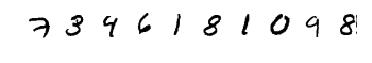

In [4]:

# display image
def display(imgs):
    n=imgs.size / image_size
    i=1
    for img in imgs:
        plt.subplot(1,n,i)
        plt.axis('off')
        plt.imshow(img.reshape(28,28), cmap=cm.binary)
        i=i+1

# output images
display(mnist.train.images[0:10])

In [5]:
# Parameters
learning_rate = 0.01
epochs = 1
batch_size = 100
display_epoch = 1

In [6]:
# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

The first layer is a convolution, followed by max pooling. The convolution computes 32 features for each 5x5 patch. Its weight tensor has a shape of [5, 5, 1, 32]. The first two dimensions are the patch size, the next is the number of input channels (1 means that images are grayscale), and the last is the number of output channels. There is also a bias vector with a component for each output channel.


To apply the layer, we reshape the input data to a 4d tensor, with the first dimension corresponding to the number of images, second and third - to image width and height, and the final dimension - to the number of colour channels.

In [7]:
# tf Graph Input
# mnist data image of shape 28*28=784
x = tf.placeholder(tf.float32, [None, 28, 28, 1], name='x')
# 0-9 digits recognition => 10 classes
labels = tf.placeholder(tf.float32, [None, 10], name='labels')

# first convolutional layer, with max pool
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

h_conv1 = tf.nn.relu(conv2d(x, W_conv1) + b_conv1)
#print (h_conv1.get_shape()) # => (40000, 28, 28, 32)
h_pool1 = max_pool_2x2(h_conv1)
#print (h_pool1.get_shape()) # => (40000, 14, 14, 32)

# second convolutional layer, with max pool
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# densely connected layer
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# drop out
keep_prob = tf.placeholder_with_default(1.0, shape=(), name="keep_prob")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# readout layer
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2


cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(labels, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

y_softmax = tf.nn.softmax(y_conv, name='y_softmax')
values, indices = tf.nn.top_k(y_softmax, 10)

table = tf.contrib.lookup.index_to_string_table_from_tensor(tf.constant([str(i) for i in range(10)]))
prediction_classes = table.lookup(tf.to_int64(indices))

tf.summary.scalar("loss", cross_entropy)
tf.summary.scalar("accuracy", accuracy)
summary_op = tf.summary.merge_all()

In [8]:
# Start training
cxt = Context("mnist-cnn", 1)

In [9]:
# Start training

saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # op to write logs to Tensorboard
    summary_writer = tf.summary.FileWriter(cxt.log_path, graph=tf.get_default_graph())
    
    total_batches = int(mnist.train.num_examples/batch_size)
    print("total batches = %s" % (total_batches))
    for e in range(epochs):
        for i in range(total_batches):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size) 
            if i % 10 == 0:
                # record summary data
                train_accuracy, summary = sess.run([accuracy, summary_op], feed_dict={x: batch_xs, labels: batch_ys, keep_prob: 1.0})
                summary_writer.add_summary(summary, e * total_batches + i)
                print('step %d, training accuracy %g' % (i, train_accuracy))
            else:
                _ = sess.run([train_step], feed_dict={x: batch_xs, labels: batch_ys, keep_prob: 0.5})

        print('step %d, training accuracy %g' % (i, train_accuracy))
        p = saver.save(sess, "%s/checkpoint.ckpt" % (cxt.checkpoint_path))
        print("Checkpoint saved to path: %s" % p)

    print('done training mnist-cnn')
    
    tensor_info_x = tf.saved_model.utils.build_tensor_info(x)
    tensor_info_y = tf.saved_model.utils.build_tensor_info(y_softmax)

    # build prediction signature
    s = signature(x, y_softmax)

    # saving model
    legacy_init_op = tf.group(tf.tables_initializer(), name='legacy_init_op')
        
    builder = tf.saved_model.builder.SavedModelBuilder(cxt.model_path)
    builder.add_meta_graph_and_variables(
        sess,[tf.saved_model.tag_constants.SERVING],
        signature_def_map = signature_def_map(s),
        legacy_init_op=legacy_init_op)
    
    
    builder.save()
    print("Model exported to path: %s" % cxt.model_path)   

total batches = 550
step 0, training accuracy 0.09
step 10, training accuracy 0.14
step 20, training accuracy 0.34
step 30, training accuracy 0.62
step 40, training accuracy 0.68
step 50, training accuracy 0.76
step 60, training accuracy 0.77
step 70, training accuracy 0.86
step 80, training accuracy 0.76
step 90, training accuracy 0.84
step 100, training accuracy 0.84
step 110, training accuracy 0.81
step 120, training accuracy 0.87
step 130, training accuracy 0.87
step 140, training accuracy 0.87
step 150, training accuracy 0.9
step 160, training accuracy 0.94
step 170, training accuracy 0.89
step 180, training accuracy 0.96
step 190, training accuracy 0.84
step 200, training accuracy 0.87
step 210, training accuracy 0.95
step 220, training accuracy 0.94
step 230, training accuracy 0.96
step 240, training accuracy 0.89
step 250, training accuracy 0.97
step 260, training accuracy 0.95
step 270, training accuracy 0.91
step 280, training accuracy 0.93
step 290, training accuracy 0.92
st